# ros-orf level 2

### Gather and analyse putative ORF data, and generate FASTA files

**Create program to assemble and analyse data on the ORFs and peptides putatively encoded in a given DNA sequence.**

Stepping up from ros-orf level 1 which had the goal of just returning a list of all the putative peptides encoded in a DNA string, in level 2 want to create a program to assemble a data frame storing useful information about the putative ORF's of a DNA sequence. 

This data frame would include:
- Unique ID; Frame and Strand; Start and end positions; ORF length and peptide size; Overlap information

I will also take the opportunity to plot some data both in R's ggplot2 (which I already know) and in python (this will be new). 

And to make the code more useful, I will make it modular. 

- [x] Gather data on putative ORF's of a DNA sequence
- [x] Plot putative ORF's in R ggplot2
- [ ] Plot putative ORF's in python
- [x] Generate FASTA files with putative ORF, mRNA or peptide sequences

### Part I: Using Pandas to assemble dataframe

In [15]:
# Import packages
from Bio import SeqIO
from Bio.Seq import Seq
import pandas as pd


# PART 1: PREPARE DNA INPUT

def fasta_dna_parser(fasta_file):
    """Parse FASTA file with DNA sequences into dataframe with DNA ID and sequence.
    
    Input: path to FASTA file
    Output: pandas dataframe"""

    # Create empty dictionary
    dna_dict = {}

    # Open and parse FASTA file, then store sequneces in dictionary
    with open(fasta_file, 'r') as file:
        for item in SeqIO.parse(file, 'fasta'):
            dna_id = item.id
            dna_seq = str(item.seq).upper()
            dna_dict[dna_id] = dna_seq

    return dna_dict
    

# PART 2: Find putative ORFs on DNA sequences

def orf_finder(dna_dict):
    """Find putative ORFs in DNA sequences provided in dataframe,
    and return dataframe with location data for putative ORFs and unique putative ORF ID.
    Note that start and stop codon location is stored as 0-based python index of the first codon nt.
    
    Input: dataframe with DNA ID and sequences    
    Output: dataframe with putative ORF location data"""

    # Set start and stop codons
    start_codon = ['ATG']
    stop_codon = ['TAA', 'TAG', 'UGA']

    # Create empty dictionary to store locations of putative ORFs
    orf_dict = {
        'Source DNA ID': [],
        'Putative ORF ID': [],
        'Strand': [],
        'Start codon index': [],
        'Stop codon index': []
    }

    # Prepare DNA from dataframe 
    for id, seq in dna_dict.items():
        dna_id = id
        dna_seq_sense = seq
        dna_seq_asense = str(Seq(dna_seq_sense).reverse_complement())

        # Search for putative ORFs and fill-out dictionary with data of found ORFs
        for dir, seq in {'Sense': dna_seq_sense, 'Antisense': dna_seq_asense}.items():
            for i in range(len(seq) - 5): 
                if seq[i:i+3] in start_codon:
                    for j in range(i+3, len(seq)-2, 3):
                        if seq[j:j+3] in stop_codon:
                            orf_id = f'{dna_id.lower()}_orf_{len(orf_dict['Putative ORF ID'])+1}'
                            orf_dict['Source DNA ID'].append(dna_id)
                            orf_dict['Putative ORF ID'].append(orf_id)
                            orf_dict['Strand'].append(dir)
                            orf_dict['Start codon index'].append(i)
                            orf_dict['Stop codon index'].append(j)
                            break
                        
    # Return dictionary with location data of putative ORFs
    return pd.DataFrame(orf_dict)



# PART 3: ASSEMBLE DATAFRAME WITH MORE PUTATIVE ORF DATA

def orf_data_collector(dna_dict, orf_locations_df):
    """Gather more data regarding putative ORFs and store it in more comprehensive dataframe.
    This data can be useful for subsequent analysis and plotting.
    Examples of data to collect:
    Location of first and last bp of putative ORF in the DNA duplex (First bp and Last bp),
    an alternative location metric similar to the aforementioned but retaining orientation of the ORF (Start and Stop),
    length of the mRNA (Length of mRNA), size of the peptide (Peptide size),
    whether putative ORF overlaps with others in the DNA duplex (Overlap in DNA)...

    Input: dataframe with locations (0-based index) of putative ORFs
    Output: comprehensive dataframe with more data on putative ORFs"""
    
    # Create expanded dataframe
    orf_extra_df = orf_locations_df.copy()

    # Initiate list for data variables:
    fromhere_dna, tohere_dna = [], [] # First and last bp of ORF in DNA duplex
    start_dna, stop_dna = [], [] # Location of start and stop codons in DNA duplex
    frame = []
    length, pept_size = [], []

    # Collect that data based on strand and position indexes of putative ORF
    for index, row in orf_locations_df.iterrows():
        start_i = row['Start codon index']
        stop_i = row['Stop codon index']
        strand = row['Strand']
        dna_id = row['Source DNA ID']
        dna_seq = dna_dict[dna_id]
        dna_len = len(dna_seq)

        # Calculate size of putative ORF and peptide
        length.append(stop_i - start_i)
        pept_size.append((stop_i - start_i) // 3)

        # Calculate frame (strand dependent)
        if (start_i + 3) % 3 == 0:
            frame.append(f'{strand} +1')
        elif (start_i + 2) % 3 == 0:
            frame.append(f'{strand} +2')
        elif (start_i + 1) % 3 == 0:
            frame.append(f'{strand} +3')

        # ORF location
        if strand == 'Sense':
            fromhere_dna.append(start_i + 1)
            tohere_dna.append(stop_i +3) 
            start_dna.append(start_i + 1)
            stop_dna.append(stop_i +3)
        elif strand == 'Antisense':
            fromhere_dna.append(dna_len - stop_i - 2)
            tohere_dna.append(dna_len - start_i)
            stop_dna.append(dna_len - stop_i - 2)
            start_dna.append(dna_len - start_i)
           
    # Add variables to dataframe
    orf_extra_df['Frame'] = frame
    orf_extra_df['Length'] = length
    orf_extra_df['Peptide size'] = pept_size 
    orf_extra_df['ORF first bp'] = fromhere_dna
    orf_extra_df['ORF last bp'] = tohere_dna
    orf_extra_df['Start bp'] = start_dna
    orf_extra_df['Stop bp'] = stop_dna

    return orf_extra_df      


### Part II: Plot putative ORF's

#### Plotting with R ggplot2:
This was done in a separate file because I couldn't make the R kernel work properly in the jupyter notebook in VS code.

See file ros-orf-level-2.r.

Resulting figure for rosalind_orf.txt:

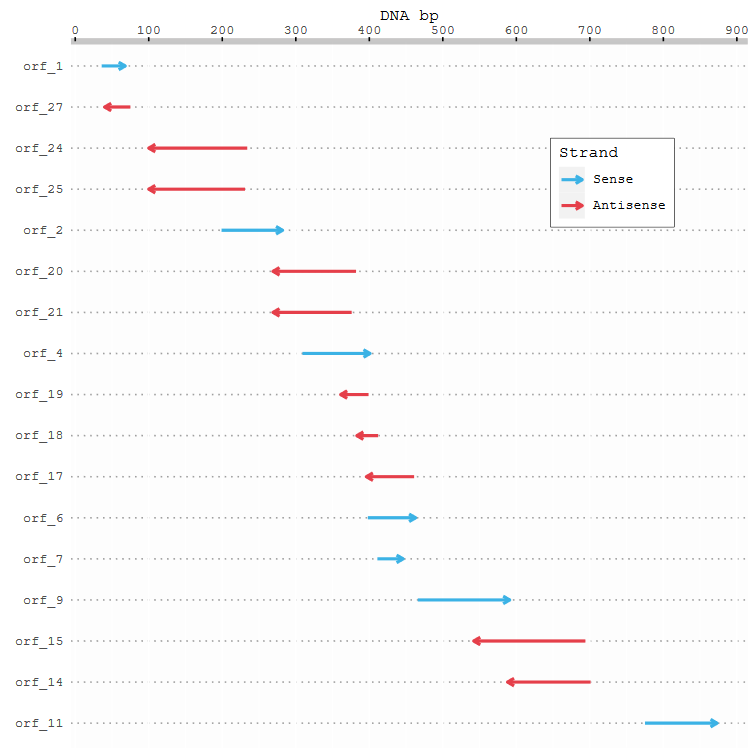

#### Plotting with Python:
***Not done yet!***

### Part III: Create FASTA files

Use putative ORF location data obtained with orf_finder function to generate putative ORF, mRNA or peptide sequences for each input DNA sequence, and store them on FASTA files.

In [14]:
# PART 4: GENERATE FASTA FILES WITH PUTATIVE ORFS

def orf_dna_fasta_generator(dna_dict, orf_df):
    """Write DNA FASTA files for putative ORFs found for each input DNA sequence. One file is created per source DNA.
    Files contains the putative ORF DNA sequences, along with ORF ID and length."""

    # Prepare input DNA sequences and start empty dictionary for putative ORFs
    for id, seq in dna_dict.items():
        putative_orfs = {}
        dna_id = id
        dna_seq_sense = seq
        dna_seq_asense = str(Seq(dna_seq_sense).reverse_complement())

        # For each DNA sequence...
        filt_orf_df = orf_df[orf_df['Source DNA ID'] == dna_id]

        # Store putative ORFs in dictionary
        for _, row in filt_orf_df.iterrows():
            if row['Strand'] == 'Sense':
                orf_seq = dna_seq_sense[row['Start codon index']:(row['Stop codon index']+3)]
            elif row['Strand'] == 'Antisense':
                orf_seq = dna_seq_asense[row['Start codon index']:(row['Stop codon index']+3)]
            putative_orfs[row['Putative ORF ID']] = orf_seq
        
        #
        orf_fasta = f"level-2/fasta-output/{dna_id}_putativeorfs.fasta"
        with open(orf_fasta, 'w') as f:
            for orf_id, seq in putative_orfs.items():
                f.write(f'>{orf_id}, {len(seq)}bp\n')
                f.write(f'{seq}\n')
    return orf_fasta


def orf_mrna_fasta_generator(dna_dict, orf_df):
    """Write RNA FASTA files for putative ORFs found for each input DNA sequence. One file is created per source DNA.
    File contains the putative ORF mRNA sequences, along with ORF ID and length"""

    # Prepare input DNA sequences and start empty dictionary for putative ORFs
    for id, seq in dna_dict.items():
        putative_mrnas = {}
        dna_id = id
        dna_seq_sense = seq
        dna_seq_asense = str(Seq(dna_seq_sense).reverse_complement())

        # For each DNA sequence...
        filt_orf_df = orf_df[orf_df['Source DNA ID'] == dna_id]

        # Store putative ORFs in dictionary
        for _, row in filt_orf_df.iterrows():
            if row['Strand'] == 'Sense':
                mrna_seq = str(Seq(dna_seq_sense[row['Start codon index']:(row['Stop codon index']+3)]).transcribe())
            elif row['Strand'] == 'Antisense':
                mrna_seq = str(Seq(dna_seq_asense[row['Start codon index']:(row['Stop codon index']+3)]).transcribe())
            putative_mrnas[row['Putative ORF ID']] = mrna_seq
        
        #
        mrna_fasta = f"level-2/fasta-output/{dna_id}_putativeorfs.fasta"
        with open(mrna_fasta, 'w') as f:
            for orf_id, seq in putative_mrnas.items():
                f.write(f'>{orf_id}, {len(seq)}bp\n')
                f.write(f'{seq}\n')
    return mrna_fasta


def orf_peptide_fasta_generator(dna_dict, orf_df):
    """Write peptide FASTA files for putative ORFs found for each input DNA sequence. One file is created per source DNA.
    File contains the putative ORF peptide sequences, along with ORF ID and size"""
    # Prepare input DNA sequences and start empty dictionary for putative ORFs
    for id, seq in dna_dict.items():
        putative_pepts = {}
        dna_id = id
        dna_seq_sense = seq
        dna_seq_asense = str(Seq(dna_seq_sense).reverse_complement())

        # For each DNA sequence...
        filt_orf_df = orf_df[orf_df['Source DNA ID'] == dna_id]

        # Store putative ORFs in dictionary
        for _, row in filt_orf_df.iterrows():
            if row['Strand'] == 'Sense':
                pept_seq = str(Seq(dna_seq_sense[row['Start codon index']:(row['Stop codon index']+3)]).translate(to_stop=True))
            elif row['Strand'] == 'Antisense':
                pept_seq = str(Seq(dna_seq_asense[row['Start codon index']:(row['Stop codon index']+3)]).translate(to_stop=True))
            putative_pepts[row['Putative ORF ID']] = pept_seq
        
        #
        pept_fasta = f"level-2/fasta-output/{dna_id}_putativeorfs.fasta"
        with open(pept_fasta, 'w') as f:
            for orf_id, seq in putative_pepts.items():
                f.write(f'>{orf_id}, {len(seq)}aa\n')
                f.write(f'{seq}\n')
    return pept_fasta

### Testing performance

***Missing***


In [16]:
import os
os.chdir('C:/Users/joanaq/Documents/learning-bioinformatics/projects/ros-orf')

# 1kb
dna_dict_1kb = fasta_dna_parser('sample-dna-seqs/rosalind_orf.txt')
orf_df_1kb = orf_finder(dna_dict_1kb)
orf_extra_df_1kb = orf_data_collector(dna_dict_1kb, orf_df_1kb)
orf_extra_df_1kb.to_csv(f"level-2/csv-output/sample1kb_putativeorfs.csv", encoding='utf-8', index=False)

orf_dna_fasta_generator(dna_dict_1kb, orf_df_1kb)
orf_mrna_fasta_generator(dna_dict_1kb, orf_df_1kb)
orf_peptide_fasta_generator(dna_dict_1kb, orf_df_1kb)

'level-2/fasta-output/Rosalind_3903_putativeorfs.fasta'

In [17]:
import os
os.chdir('C:/Users/joanaq/Documents/learning-bioinformatics/projects/ros-orf')

# 10kb
dna_dict_10kb = fasta_dna_parser('sample-dna-seqs/randomseq_10kb.fasta')
orf_df_10kb = orf_finder(dna_dict_10kb)
orf_data_collector(dna_dict_10kb, orf_df_10kb)

orf_dna_fasta_generator(dna_dict_10kb, orf_df_10kb)
orf_mrna_fasta_generator(dna_dict_10kb, orf_df_10kb)
orf_peptide_fasta_generator(dna_dict_10kb, orf_df_10kb)

'level-2/fasta-output/randomseq_10kb_putativeorfs.fasta'

In [18]:
import os
os.chdir('C:/Users/joanaq/Documents/learning-bioinformatics/projects/ros-orf')

# 100kb
dna_dict_100kb = fasta_dna_parser('sample-dna-seqs/randomseq_100kb.fasta')
orf_df_100kb = orf_finder(dna_dict_100kb)
orf_data_collector(dna_dict_100kb, orf_df_100kb)

orf_dna_fasta_generator(dna_dict_100kb, orf_df_100kb)
orf_mrna_fasta_generator(dna_dict_100kb, orf_df_100kb)
orf_peptide_fasta_generator(dna_dict_100kb, orf_df_100kb)

'level-2/fasta-output/randomseq_100kb_putativeorfs.fasta'

In [19]:
import os
os.chdir('C:/Users/joanaq/Documents/learning-bioinformatics/projects/ros-orf')

# 1Mb
dna_dict_1Mb = fasta_dna_parser('sample-dna-seqs/randomseq_1Mb.fasta')
orf_df_1Mb = orf_finder(dna_dict_1Mb)
orf_data_collector(dna_dict_1Mb, orf_df_1Mb)

orf_dna_fasta_generator(dna_dict_1Mb, orf_df_1Mb)
orf_mrna_fasta_generator(dna_dict_1Mb, orf_df_1Mb)
orf_peptide_fasta_generator(dna_dict_1Mb, orf_df_1Mb)

'level-2/fasta-output/randomseq_1Mb_putativeorfs.fasta'

### Final Thoughts

To summarise improvements from previous level 2 version:
- Functions make program usable with different input files
- Removed redundancies and unnecessary steps (for example: doing the ORF search directly in DNA rather than converting to RNA before searching)
- Code more organized and easy to read
- Performs better (can handle 1Mb DNA sequences)

It has been a good exercise think about how to re-organize the code into modules/functions. Plus, although the program itself is not very useful, it could be that the functions themselves may be in the future.

I was also positively surprised by the performance of the functions. I thought it would be worse, since the previous version took was taking more than 1 minute to run with a 1Mb sequence. Now I am really curious about how would it do with multiple sequences - this is something I will be focusing on next level.

Thinking about further improvements in the next level:
- There must be a better way to store the DNA sequences - biopython records??
- Does biopython also help writing fasta files?


**Missing**:
- Improve overlaps module
- Plot in Python

